In [1]:
# imports etc.

import sys, os
sys.path.append(os.path.abspath('../'))

from src.utils.flow import *
from src.utils.flow_calculations import *
from src.utils.restoration import *
from src.utils.truncated_packet import *
from src.operations.size_perturbation_logic import *
from src.operations.timing_perturbation_logic import *
from src.operations.calculate_fitness import *

In [2]:
# data preparation

In [126]:
captures = [
    "botnet-capture-20110811-neris",
    "botnet-capture-20110812-rbot",
    "botnet-capture-20110815-fast-flux-2",
    "botnet-capture-20110815-fast-flux",
    "botnet-capture-20110815-rbot-dos",
    "botnet-capture-20110816-donbot",
    "botnet-capture-20110816-qvod",
    "botnet-capture-20110816-sogou",
    "botnet-capture-20110817-bot",
    "botnet-capture-20110818-bot-2",
    "botnet-capture-20110819-bot"
]

In [4]:
import numpy as np

def mean_dicts(dicts):
    keys = set(k for d in dicts for k in d)
    mean_dict = {}
    for key in keys:
        mean_dict[key] = np.mean([d[key] for d in dicts if key in d])
    return mean_dict

def median_dicts(dicts):
    keys = set(k for d in dicts for k in d)
    median_dict = {}
    for key in keys:
        values = [d[key] for d in dicts if key in d]
        median_dict[key] = np.median(values) if values else 0
    return median_dict

def calculate_distance(flow_stats, median_stats):
    return sum((flow_stats[key] - median_stats[key])**2 for key in median_stats)

mean_flows = []
median_flows = []
all_median_flow_packets = []

for i in range(len(captures)):
    print(f'Working on capture: {captures[i]}')

    pcap_file_path = f'../data/raw/filtered/{captures[i]}.pcap'
    model_name = f'{captures[i]}'

    truncated_packets = create_truncated_packets_from_pcap(pcap_file_path)
    print(f"Total packets loaded: {len(truncated_packets)}")

    truncated_packets = assign_flow_ids_to_packets(truncated_packets)

    flow_ids = set(packet.flow_id for packet in truncated_packets)
    flows = []

    for fid in flow_ids:
        sizing_stats = prepare_size_stats(truncated_packets, fid)
        timing_stats = prepare_timing_stats(truncated_packets, fid)
        flow_parameters = {**sizing_stats, **timing_stats}
        flows.append(flow_parameters)
    
    mean_flow_stats = mean_dicts(flows)
    median_flow_stats = median_dicts(flows)
    
    mean_flows.append(mean_flow_stats)
    median_flows.append(median_flow_stats)

    # Find the flow ID that matches the median statistics and has more than 4 packets
    median_flow_ids = set()
    min_distance = float('inf')
    closest_flow_id = None
    
    for fid in flow_ids:
        flow_stats = {**prepare_size_stats(truncated_packets, fid), **prepare_timing_stats(truncated_packets, fid)}
        
        distance = calculate_distance(flow_stats, median_flows[i])
        if distance < min_distance:
            # Check if the flow has more than 4 packets
            flow_packet_count = sum(1 for packet in truncated_packets if packet.flow_id == fid)
            if flow_packet_count > 4:
                min_distance = distance
                closest_flow_id = fid
    
    if closest_flow_id is not None:
        median_flow_ids.add(closest_flow_id)
    
    print(f"Closest median flow ID for capture {captures[i]}: {closest_flow_id}")
    median_flow_packets = [packet for packet in truncated_packets if packet.flow_id in median_flow_ids]
    all_median_flow_packets.append(median_flow_packets)

print("Mean flows calculated:")
print(mean_flows)
print("Median flows calculated:")
print(median_flows)
print("Packets with median flow IDs extracted (organized by capture):")
for i, packets in enumerate(all_median_flow_packets):
    print(f"Capture {captures[i]}: {len(packets)} packets")


Working on capture: botnet-capture-20110811-neris
Total packets loaded: 4955
hash groups: 593
Closest median flow ID for capture botnet-capture-20110811-neris: 28
Working on capture: botnet-capture-20110812-rbot
Total packets loaded: 4958
hash groups: 449
Closest median flow ID for capture botnet-capture-20110812-rbot: 858
Working on capture: botnet-capture-20110815-fast-flux-2
Total packets loaded: 4973
hash groups: 366
Closest median flow ID for capture botnet-capture-20110815-fast-flux-2: 18
Working on capture: botnet-capture-20110815-fast-flux
Total packets loaded: 4968
hash groups: 139
Closest median flow ID for capture botnet-capture-20110815-fast-flux: 123
Working on capture: botnet-capture-20110815-rbot-dos
Total packets loaded: 2653
hash groups: 85
Closest median flow ID for capture botnet-capture-20110815-rbot-dos: 5
Working on capture: botnet-capture-20110816-donbot
Total packets loaded: 4952
hash groups: 657
Closest median flow ID for capture botnet-capture-20110816-donbot:

In [5]:
all_median_flow_packets

[[TruncatedPacket(packet_id=322, timestamp=1313051675.824749, size=62, pseudo_hash='2131667670289267383', flow_id=28, direction='1', src_ip=147.32.84.165, fragmented=0, tcp=1, udp=0, fin=0, syn=1, rst=0, ack=0, psh=0, urg=0),
  TruncatedPacket(packet_id=323, timestamp=1313051675.824968, size=60, pseudo_hash='2131667670289267383', flow_id=28, direction='2', src_ip=147.32.84.218, fragmented=0, tcp=1, udp=0, fin=0, syn=1, rst=0, ack=1, psh=0, urg=0),
  TruncatedPacket(packet_id=324, timestamp=1313051675.825197, size=126, pseudo_hash='2131667670289267383', flow_id=28, direction='1', src_ip=147.32.84.165, fragmented=0, tcp=1, udp=0, fin=0, syn=0, rst=0, ack=1, psh=1, urg=0),
  TruncatedPacket(packet_id=325, timestamp=1313051675.825414, size=60, pseudo_hash='2131667670289267383', flow_id=28, direction='2', src_ip=147.32.84.218, fragmented=0, tcp=1, udp=0, fin=1, syn=0, rst=0, ack=1, psh=0, urg=0),
  TruncatedPacket(packet_id=326, timestamp=1313051675.825647, size=60, pseudo_hash='21316676702

In [6]:
# IN ORDER TO PREDICT (FOR TARGET MODEL): predict_single_flow_target(model_name, flow_parameters[0], flow_parametrs[1])

In [7]:
# data testing

In [8]:
    # gen alg

In [9]:
def apply_best_on_packets(packets, max_fitness, flow_id):

    index = max_fitness[1][2]
    if index == 0:
        return packets
    
    params = max_fitness[1][1][index-1] # best technique
    
    if index == 1:     
        return adjust_packet_size(packets, flow_id, params['direction'], 'normal', params['scaling_factor'], params['focus_point'])
                   
    elif index == 2:
        return adjust_packet_size(packets, flow_id, params['direction'], 'uniform', params['scaling_factor'], params['focus_point'])
                
    elif index == 3:
        return apply_time_perturbation_with_focus(packets, flow_id, 'normal', params['focus_point'], params['scaling_factor'])
                
    elif index == 4:
        return apply_time_perturbation_with_focus(packets, flow_id, 'uniform', params['focus_point'], params['scaling_factor'])
        
    return packets

In [10]:
import pygad
import copy

class FlowOptimizer:
    def __init__(self, packets, model_name, flow_id, max_fitness, target):
        self.packets = packets
        self.model_name = model_name
        self.flow_id = flow_id
        self.ga_instance = None
        self.max_fitness = max_fitness
        self.target = target
        
    def apply_best_solution(self):
        best_solution, best_solution_fitness, _ = self.ga_instance.best_solution()
        best_operations = self.decode_operations(best_solution)
        # Stosujemy najlepsze operacje do pakietów
        self.best_modified_packets = self.apply_operations_to_packets(best_operations, self.packets, self.flow_id)
        return self.best_modified_packets, best_solution_fitness

    def on_generation(self, ga_instance):
        pass
            
    def on_fitness(self, ga_instance):
        ga_instance.plot_fitness()

    def fitness_function(self, ga_instance, solution, solution_idx):
        
        fitnesses = []
        target_fitnesses = []
        
        operations = self.decode_operations(solution)
        
        modified_packets = self.packets # always check nop
        sizing_stats = prepare_size_stats(modified_packets, self.flow_id)
        timing_stats = prepare_timing_stats(modified_packets, self.flow_id)
        fitnesses.append(1.0 - predict_single_flow(self.model_name, sizing_stats, timing_stats))
        target_fitnesses.append(1.0 - predict_single_flow_target(self.model_name, sizing_stats, timing_stats))
        
        modified_packets = self.apply_operations_to_packets(operations[0], op_type = 'size_norm')
        sizing_stats = prepare_size_stats(modified_packets, self.flow_id)
        #print(sizing_stats)
        timing_stats = prepare_timing_stats(modified_packets, self.flow_id)
        fitnesses.append(1.0 - predict_single_flow(self.model_name, sizing_stats, timing_stats))
        target_fitnesses.append(1.0 - predict_single_flow_target(self.model_name, sizing_stats, timing_stats))
        
        modified_packets = self.apply_operations_to_packets(operations[1], op_type = 'size_uni')
        sizing_stats = prepare_size_stats(modified_packets, self.flow_id)
        timing_stats = prepare_timing_stats(modified_packets, self.flow_id)
        fitnesses.append(1.0 - predict_single_flow(self.model_name, sizing_stats, timing_stats))
        target_fitnesses.append(1.0 - predict_single_flow_target(self.model_name, sizing_stats, timing_stats))
        
        modified_packets = self.apply_operations_to_packets(operations[2], op_type = 'time_norm')
        sizing_stats = prepare_size_stats(modified_packets, self.flow_id)
        timing_stats = prepare_timing_stats(modified_packets, self.flow_id)
        fitnesses.append(1.0 - predict_single_flow(self.model_name, sizing_stats, timing_stats))
        target_fitnesses.append(1.0 - predict_single_flow_target(self.model_name, sizing_stats, timing_stats))
        
        modified_packets = self.apply_operations_to_packets(operations[3], op_type = 'time_uni')
        sizing_stats = prepare_size_stats(modified_packets, self.flow_id)
        timing_stats = prepare_timing_stats(modified_packets, self.flow_id)
        fitnesses.append(1.0 - predict_single_flow(self.model_name, sizing_stats, timing_stats))
        target_fitnesses.append(1.0 - predict_single_flow_target(self.model_name, sizing_stats, timing_stats))

        if self.target:
            max_fitness_value = max(target_fitnesses)
            max_fitness_index = target_fitnesses.index(max_fitness_value) 

        else:
            max_fitness_value = max(fitnesses) 
            max_fitness_index = fitnesses.index(max_fitness_value) 

        max_fitness_target = target_fitnesses[max_fitness_index]

        #print(self.max_fitness)
        if max_fitness_value > self.max_fitness[0][0]:
            #print(f'CONDITION max: {max_fitness_value}, prev: {self.max_fitness[0]}')
            self.max_fitness = [[max_fitness_value, max_fitness_target], self.decode_operations(solution), max_fitness_index]
            #print(f'self:{self.max_fitness[0]}')
        
        #print(max_fitness_value)
        #print(f'solution:{solution}')
        #print(f'finresses: {fitnesses}, solution:{self.decode_operations(solution)}')
        
        return max_fitness_value

    def optimize_for_flow(self):
        
        #with open(f"progress_for_flow_{self.flow_id}.txt", "w") as file:
        #    file.write("")  # Tylko czyszczenie zawartości pliku
            
        ga_instance = pygad.GA(num_generations=2,
                               num_parents_mating=1,
                               fitness_func=self.fitness_function,
                               sol_per_pop=3,                          
                               mutation_probability=0.7,
                               suppress_warnings= True,
                               on_generation=self.on_generation,
                               num_genes=6, # operations number
                               gene_space = [{'low': 1.1, 'high': 5.0},  # size normal
                                             {'low': 0.25, 'high': 5.0}, # packet size uniform
                                             {'low': 1.1, 'high': 3.0}, # time normal
                                             {'low': 0.4, 'high': 2.4}, # time uniform
                                            [0,1,2],  # direction
                                            [0,1,2]]) # focus point 

        
        ga_instance.run()
        return ga_instance, self.max_fitness

    def decode_operations(self, genotype):
        operations = []
        

        focus_point_map = {0: "start", 1: "middle", 2: "end"}
        focus_point = None
        focus_point_index = genotype[5] 
        focus_point = focus_point_map.get(focus_point_index, None)  

        size_norm = {
            'scaling_factor': genotype[0],
            'direction': genotype[4],
            'focus_point': focus_point
        }
        
        size_uni = {
            'scaling_factor': genotype[1],
            'direction': genotype[4],
            'focus_point': focus_point
        }
        
        time_norm = {
            'scaling_factor': genotype[2],
            'direction': genotype[4],
            'focus_point': focus_point
        }
        
        
        time_uni = {
            'scaling_factor': genotype[3],
            'direction': genotype[4],
            'focus_point': focus_point
        }  
            
            
        
        operations = [size_norm, size_uni, time_norm, time_uni]
        return operations 
        


    def apply_operations_to_packets(self, operation, op_type):


        scaling_factor = operation['scaling_factor']
        direction = operation.get('direction')
        focus_point = operation.get('focus_point')
        

        if op_type == 'size_norm':
            packets = adjust_packet_size_deepcopy(self.packets, self.flow_id, direction, 'normal', scaling_factor, focus_point)
            
            
        elif op_type == 'size_uni':
            packets = adjust_packet_size_deepcopy(self.packets, self.flow_id, direction, 'uniform', scaling_factor, focus_point)
            
        elif op_type == 'time_norm':
            packets = apply_time_perturbation_with_focus_deepcopy(self.packets, self.flow_id, 'normal', focus_point, scaling_factor)
            
        elif op_type == 'time_uni':
            #print(f'przed: {prepare_timing_stats(self.packets, self.flow_id)}')
            packets = apply_time_perturbation_with_focus_deepcopy(self.packets, self.flow_id, 'uniform', focus_point, scaling_factor)
            #print(f'po: {prepare_timing_stats(packets, self.flow_id)}')
            
        #print(packets)
        return packets
    
    


In [18]:
import copy
import os
import pickle


median_attributes = []

def process_flow_id(flow_id, packets, model, target=False):
    print(f"Starting work on flow_id: {flow_id}")
    truncated_packets = copy.deepcopy(packets)  
    inter = []
    max_fitness = [0, [[0, 0], 0, 0], 0]
    previous_max = 0

    attributes = [[], []]
    for i in range(5):
        optimizer = FlowOptimizer(truncated_packets, model, flow_id, max_fitness[1], target)
        max_fitness = optimizer.optimize_for_flow()
        
        if max_fitness[1][0][0] > previous_max:
            truncated_packets = apply_best_on_packets(truncated_packets, max_fitness, flow_id)
            previous_max = max_fitness[1][0][0]
            attributes[0].append(max_fitness[1][2]) # TUTAJ APPEND (op.)
            attributes[1].append(max_fitness[1][1][attributes[0][i]-1]) # APPEND -> direction, scaling factor, focus point (p.)
        else:
            attributes[0].append(-1) 
            attributes[1].append(-1) 
            
    sizing_stats = prepare_size_stats(truncated_packets, flow_id)
    timing_stats = prepare_timing_stats(truncated_packets, flow_id)
    accuracy = predict_single_flow(model_name, sizing_stats, timing_stats)

    return flow_id, attributes, truncated_packets, 1.0 - previous_max # TODO: albo accuracy

def main():

    updated_truncated_packets_list = []


    # FITNESS FUNCTION RF
    for i in range(0, len(captures)):
        print(f'Working on mean flows capture for: {captures[i]}')

        model_name = f'{captures[i]}'

        updated_truncated_packets = all_median_flow_packets[i]

        flow_id, attributes, updated_truncated_packets, accuracy = process_flow_id(all_median_flow_packets[i][0].flow_id, updated_truncated_packets, model_name, target=False) # for this experiment it doesn't really matter if the target is True or False
        median_attributes.append(attributes)

        
        print(f"Completed processing flow for capture {captures[i]}, final results: {attributes}, accuracy: {accuracy}")
        updated_truncated_packets_list.append(updated_truncated_packets)

    #print(median_attributes)


if __name__ == "__main__":
    main()


Working on mean flows capture for: botnet-capture-20110811-neris
Starting work on flow_id: 28
Completed processing flow for capture botnet-capture-20110811-neris, final results: [[2, 2, 4, 1, 4], [{'scaling_factor': 4.171979122303853, 'direction': 0.0, 'focus_point': 'middle'}, {'scaling_factor': 4.1602507410792455, 'direction': 0.0, 'focus_point': 'end'}, {'scaling_factor': 0.6171407617023715, 'direction': 1.0, 'focus_point': 'end'}, {'scaling_factor': 2.1963093971169574, 'direction': 0.0, 'focus_point': 'end'}, {'scaling_factor': 0.5637380421089234, 'direction': 0.0, 'focus_point': 'end'}]], accuracy: 0.8310984413793879
Working on mean flows capture for: botnet-capture-20110812-rbot
Starting work on flow_id: 858
Completed processing flow for capture botnet-capture-20110812-rbot, final results: [[1, 1, 2, 4, 4], [{'scaling_factor': 2.929183216720727, 'direction': 2.0, 'focus_point': 'start'}, {'scaling_factor': 4.364231351993137, 'direction': 0.0, 'focus_point': 'end'}, {'scaling_fact

In [ ]:
    #TODO: funkcja, która na podstawie tej 5-rekordowej listy + mean flow, zastosuje wszystkie operacje i zwróci wynik



In [13]:
median_attributes

[[[4, 2, 2, 4, 1],
  [{'scaling_factor': 0.7336138343250459,
    'direction': 2.0,
    'focus_point': 'start'},
   {'scaling_factor': 3.8019975022045016,
    'direction': 0.0,
    'focus_point': 'start'},
   {'scaling_factor': 2.1544597555986487,
    'direction': 0.0,
    'focus_point': 'end'},
   {'scaling_factor': 0.5871945687123764,
    'direction': 1.0,
    'focus_point': 'start'},
   {'scaling_factor': 3.2002865877566284,
    'direction': 2.0,
    'focus_point': 'middle'}]],
 [[1, 2, 1, 4, 1],
  [{'scaling_factor': 4.406813301483362,
    'direction': 0.0,
    'focus_point': 'middle'},
   {'scaling_factor': 4.542302514960093,
    'direction': 0.0,
    'focus_point': 'end'},
   {'scaling_factor': 3.539130059551553,
    'direction': 0.0,
    'focus_point': 'end'},
   {'scaling_factor': 2.3911152793316215,
    'direction': 2.0,
    'focus_point': 'middle'},
   {'scaling_factor': 4.6335821498771805,
    'direction': 1.0,
    'focus_point': 'start'}]],
 [[2, 2, 2, 2, 4],
  [{'scaling_fa

In [14]:
all_median_flow_packets

[[TruncatedPacket(packet_id=322, timestamp=1313051675.824749, size=62, pseudo_hash='2131667670289267383', flow_id=28, direction='1', src_ip=147.32.84.165, fragmented=0, tcp=1, udp=0, fin=0, syn=1, rst=0, ack=0, psh=0, urg=0),
  TruncatedPacket(packet_id=323, timestamp=1313051675.824968, size=60, pseudo_hash='2131667670289267383', flow_id=28, direction='2', src_ip=147.32.84.218, fragmented=0, tcp=1, udp=0, fin=0, syn=1, rst=0, ack=1, psh=0, urg=0),
  TruncatedPacket(packet_id=324, timestamp=1313051675.825197, size=126, pseudo_hash='2131667670289267383', flow_id=28, direction='1', src_ip=147.32.84.165, fragmented=0, tcp=1, udp=0, fin=0, syn=0, rst=0, ack=1, psh=1, urg=0),
  TruncatedPacket(packet_id=325, timestamp=1313051675.825414, size=60, pseudo_hash='2131667670289267383', flow_id=28, direction='2', src_ip=147.32.84.218, fragmented=0, tcp=1, udp=0, fin=1, syn=0, rst=0, ack=1, psh=0, urg=0),
  TruncatedPacket(packet_id=326, timestamp=1313051675.825647, size=60, pseudo_hash='21316676702

In [19]:
def apply_best_on_packets_xai(packets, attributes, flow_id):
    for i in range(5):
        index = attributes[0][i]
        if index == 0 or index == -1:
            return packets
        
        params = attributes[1][i]
        
        if index == 1:     
            packets = adjust_packet_size(packets, flow_id, params['direction'], 'normal', params['scaling_factor'], params['focus_point'])
                   
        elif index == 2:
            packets = adjust_packet_size(packets, flow_id, params['direction'], 'uniform', params['scaling_factor'], params['focus_point'])
                
        elif index == 3:
            packets = apply_time_perturbation_with_focus(packets, flow_id, 'normal', params['focus_point'], params['scaling_factor'])
                
        elif index == 4:
            packets = apply_time_perturbation_with_focus(packets, flow_id, 'uniform', params['focus_point'], params['scaling_factor'])
        
    return packets

def apply_attributes(median_attributes, packet_set, model_name):
    total_accuracy = 0.0
    median_attr = median_attributes
    flow_id = packet_set[0].flow_id if packet_set else None
    packets = apply_best_on_packets_xai(packet_set, median_attr, flow_id)
    sizing_stats = prepare_size_stats(packets, flow_id)
    timing_stats = prepare_timing_stats(packets, flow_id)
    accuracy = predict_single_flow(model_name, sizing_stats, timing_stats)
    return accuracy

# Example usage
for i in range(0, len(captures)):
    print(f'Working on mean flows capture for: {captures[i]}')

    model_name = f'{captures[i]}'

    all_median_flow_packets_copy = copy.deepcopy(all_median_flow_packets) 
    

    accuracy = apply_attributes(median_attributes[i], all_median_flow_packets_copy[i], model_name)
    print(f"Overall accuracy: {accuracy}")


Working on mean flows capture for: botnet-capture-20110811-neris
Overall accuracy: 0.8310984413793879
Working on mean flows capture for: botnet-capture-20110812-rbot
Overall accuracy: 0.6218376350328524
Working on mean flows capture for: botnet-capture-20110815-fast-flux-2
Overall accuracy: 0.8407054743090607
Working on mean flows capture for: botnet-capture-20110815-fast-flux
Overall accuracy: 0.4877339187341012
Working on mean flows capture for: botnet-capture-20110815-rbot-dos
Overall accuracy: 0.45740291792778237
Working on mean flows capture for: botnet-capture-20110816-donbot
Overall accuracy: 0.4918480351277427
Working on mean flows capture for: botnet-capture-20110816-qvod
Overall accuracy: 0.5082377849746181
Working on mean flows capture for: botnet-capture-20110816-sogou
Overall accuracy: 0.6145224111638085
Working on mean flows capture for: botnet-capture-20110817-bot
Overall accuracy: 0.9309706975849324
Working on mean flows capture for: botnet-capture-20110818-bot-2
Overal

In [27]:
# xai preparation & perturbation functions

import pandas as pd

def transform_attributes_to_df(median_attributes):
    columns = [
        "operation_1", "scaling_factor_1", "direction_1", "focus_point_1",
        "operation_2", "scaling_factor_2", "direction_2", "focus_point_2",
        "operation_3", "scaling_factor_3", "direction_3", "focus_point_3",
        "operation_4", "scaling_factor_4", "direction_4", "focus_point_4",
        "operation_5", "scaling_factor_5", "direction_5", "focus_point_5"
    ]
    
    data = []
    
    for attrs in median_attributes:
        row = []
        operations, params = attrs
        
        for i in range(5):
            row.append(operations[i])
            if params[i] == -1:
                row.extend([-1, -1, -1])
            else:
                row.append(params[i]['scaling_factor'])
                row.append(params[i]['direction'])
                row.append(params[i]['focus_point'])
        
        data.append(row)
    
    df = pd.DataFrame(data, columns=columns)
    return df

transform_attributes_to_df(median_attributes)

,operation_1,scaling_factor_1,direction_1,focus_point_1,operation_2,scaling_factor_2,direction_2,focus_point_2,operation_3,scaling_factor_3,direction_3,focus_point_3,operation_4,scaling_factor_4,direction_4,focus_point_4,operation_5,scaling_factor_5,direction_5,focus_point_5
0,2,4.171979,0.0,middle,2,4.160251,0.0,end,4,0.617141,1.0,end,1,2.196309,0.0,end,4,0.563738,0.0,end
1,1,2.929183,2.0,start,1,4.364231,0.0,end,2,4.647507,0.0,middle,4,1.950239,2.0,middle,4,1.266383,1.0,start
2,3,1.125993,2.0,middle,2,3.666261,0.0,middle,2,4.962050,1.0,start,-1,-1.000000,-1.0,-1,-1,-1.000000,-1.0,-1
3,4,2.046971,0.0,middle,2,3.738646,0.0,end,2,2.469720,1.0,start,4,1.962771,2.0,start,4,2.389807,2.0,middle
4,2,4.498352,0.0,end,4,1.802154,1.0,end,1,2.575967,1.0,start,2,2.903156,0.0,middle,-1,-1.000000,-1.0,-1
5,2,0.380518,2.0,start,2,2.547831,1.0,start,4,2.146461,1.0,end,4,2.386255,2.0,start,4,1.580274,0.0,end
6,1,3.951195,0.0,middle,4,2.230237,1.0,end,2,1.856634,0.0,end,2,4.327345,1.0,middle,2,3.907427,1.0,start
7,2,4.888796,0.0,start,2,2.925021,1.0,end,-1,-1.000000,-1.0,-1,2,1.455757,1.0,end,2,2.579873,1.0,end
8,2,0.325714,0.0,middle,2,2.669790,1.0,end,1,4.752155,1.0,end,2,4.446724,0.0,middle,2,4.276142,1.0,start
9,2,4.095824,0.0,middle,4,1.771878,0.0,middle,4,2.270213,1.0,start,4,1.548614,2.0,start,4,2.363648,2.0,middle


In [29]:
def df_to_median_attributes(df):
    median_attributes = []
    for _, row in df.iterrows():
        operations = [
            row["operation_1"], row["operation_2"], row["operation_3"],
            row["operation_4"], row["operation_5"]
        ]
        params = []
        for i in range(1, 6):
            if row[f"operation_{i}"] == -1:
                params.append(-1)
            else:
                param = {
                    "scaling_factor": row[f"scaling_factor_{i}"],
                    "direction": row[f"direction_{i}"],
                    "focus_point": row[f"focus_point_{i}"]
                }
                params.append(param)
        median_attributes.append([operations, params])
    return median_attributes

median_attributes == df_to_median_attributes(transform_attributes_to_df(median_attributes))

True

In [32]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.6/540.6 kB 10.0 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 66.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 18.4 MB/s eta 0:00:0000:0100:01m


In [33]:
df = transform_attributes_to_df(median_attributes)

In [35]:
# filtering out operations columns, because they shouldn't be included in shap analysis

df_filtered = df.drop(columns=["operation_1", "operation_2", "operation_3", "operation_4", "operation_5"])
df_operations = df[["operation_1", "operation_2", "operation_3", "operation_4", "operation_5"]]

In [60]:
from sklearn.preprocessing import OneHotEncoder

def encode_focus_points(df, focus_point_columns):
    encoder = OneHotEncoder(sparse=False)
    encoded_df = df.copy()
    encoders = {}
    
    for column in focus_point_columns:
        encoded_df[column] = encoded_df[column].astype(str)  # Ensure all values are strings
        encoded_values = encoder.fit_transform(encoded_df[[column]])
        encoders[column] = encoder
        encoded_df = encoded_df.drop(column, axis=1)
        for i, category in enumerate(encoder.categories_[0]):
            encoded_df[f"{column}_{category}"] = encoded_values[:, i]
            
    return encoded_df, encoders

focus_point_columns = ["focus_point_1", "focus_point_2", "focus_point_3", "focus_point_4", "focus_point_5"]
encoded_df, encoders = encode_focus_points(df_filtered, focus_point_columns)
print(encoded_df)


    scaling_factor_1  direction_1  scaling_factor_2  direction_2  \
0           4.171979          0.0          4.160251          0.0   
1           2.929183          2.0          4.364231          0.0   
2           1.125993          2.0          3.666261          0.0   
3           2.046971          0.0          3.738646          0.0   
4           4.498352          0.0          1.802154          1.0   
5           0.380518          2.0          2.547831          1.0   
6           3.951195          0.0          2.230237          1.0   
7           4.888796          0.0          2.925021          1.0   
8           0.325714          0.0          2.669790          1.0   
9           4.095824          0.0          1.771878          0.0   
10          2.193634          2.0         -1.000000         -1.0   

    scaling_factor_3  direction_3  scaling_factor_4  direction_4  \
0           0.617141          1.0          2.196309          0.0   
1           4.647507          0.0          1.95

/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarn

In [160]:
columns = X.columns

In [163]:
import pandas as pd
import numpy as np

def reverse_encode_focus_points(encoded_values, column_names, focus_point_columns, encoders):
    # Create DataFrame from the values and column names
    encoded_df = pd.DataFrame(encoded_values, columns=column_names)
    decoded_df = encoded_df.copy()
    
    for column in focus_point_columns:
        encoder = encoders[column]
        # Extract the columns related to this focus point
        related_cols = [col for col in encoded_df.columns if col.startswith(column)]
        # Find the column with the max value for each row (one-hot encoding)
        max_col_indices = encoded_df[related_cols].values.argmax(axis=1)
        decoded_values = encoder.categories_[0][max_col_indices]
        decoded_df[column] = decoded_values
        # Drop the one-hot encoded columns
        decoded_df = decoded_df.drop(columns=related_cols)
        
    return decoded_df

# Example usage
# reverse_encode_focus_points(encoded_values, column_names, focus_point_columns, encoders)


In [174]:
# TODO: ten predict przestal dzialac prawidlowo po rozdzieleniu columns od values

def predict(xai_df, i = 0, columns = columns): # TODO i 0
    xai_df = reverse_encode_focus_points(xai_df, columns, focus_point_columns, encoders)
    full_df = pd.concat([xai_df, df_operations])
    median_attributes = df_to_median_attributes(full_df)
    all_median_flow_packets_copy = copy.deepcopy(all_median_flow_packets[i])
    model_name = f"{captures[i]}"
    accuracy = apply_attributes(median_attributes[i], all_median_flow_packets_copy, model_name)

    #return np.column_stack((accuracy, 1.0 - accuracy))
    return [accuracy]

In [96]:
X = encoded_df.iloc[[1]]

In [181]:
X

,scaling_factor_1,direction_1,scaling_factor_2,direction_2,scaling_factor_3,direction_3,scaling_factor_4,direction_4,scaling_factor_5,direction_5,...,focus_point_3_middle,focus_point_3_start,focus_point_4_-1,focus_point_4_end,focus_point_4_middle,focus_point_4_start,focus_point_5_-1,focus_point_5_end,focus_point_5_middle,focus_point_5_start
1,2.929183,2.0,4.364231,0.0,4.647507,0.0,1.950239,2.0,1.266383,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [183]:
# TODO: naprawic explainer tutaj - byc moze na poziomie predykcji cos jest skopane i nie ma wariancji?

predict_wrapper = lambda X: predict(X, 0) # test
    
explainer = shap.Explainer(predict_wrapper, X.values, feature_names = X.columns)
    
shap_values = explainer(X)
print(shap_values)

.values =
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

.base_values =
array([0.93157465])

.data =
array([[2.92918322, 2.        , 4.36423135, 0.        , 4.64750658,
        0.        , 1.95023932, 2.        , 1.26638333, 1.        ,
        0.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 1.        ]])


Full DF NaNs: scaling_factor_1    11
direction_1         11
scaling_factor_2    11
direction_2         11
scaling_factor_3    11
direction_3         11
scaling_factor_4    11
direction_4         11
scaling_factor_5    11
direction_5         11
focus_point_1       11
focus_point_2       11
focus_point_3       11
focus_point_4       11
focus_point_5       11
operation_1          1
operation_2          1
operation_3          1
operation_4          1
operation_5          1
dtype: int64
Median Attributes: [[[nan, nan, nan, nan, nan], [{'scaling_factor': 2.929183216720727, 'direction': 2.0, 'focus_point': 'middle'}, {'scaling_factor': 4.364231351993137, 'direction': 0.0, 'focus_point': 'end'}, {'scaling_factor': 4.647506575654549, 'direction': 0.0, 'focus_point': 'middle'}, {'scaling_factor': 1.9502393227559263, 'direction': 2.0, 'focus_point': 'middle'}, {'scaling_factor': 1.2663833309353287, 'direction': 1.0, 'focus_point': 'start'}]], [[2.0, 2.0, 4.0, 1.0, 4.0], [{'scaling_factor': nan, '

ValueError: Image size of -628183077x600 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x650 with 3 Axes>

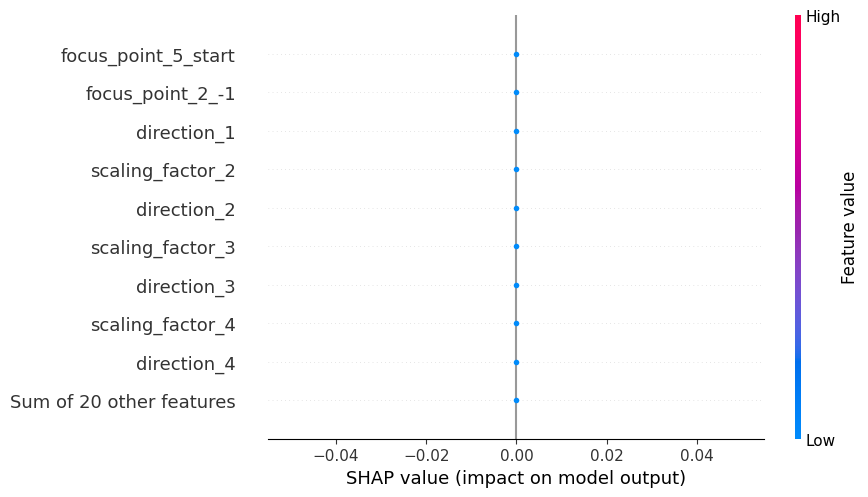

In [185]:
import pandas as pd
import numpy as np
import copy

def predict(xai_df, i=0, columns=columns):
    xai_df = reverse_encode_focus_points(xai_df, columns, focus_point_columns, encoders)
    full_df = pd.concat([xai_df, df_operations])
    
    # Check full_df for NaNs
    print("Full DF NaNs:", full_df.isna().sum())
    
    median_attributes = df_to_median_attributes(full_df)
    print("Median Attributes:", median_attributes)
    
    all_median_flow_packets_copy = copy.deepcopy(all_median_flow_packets[i])
    model_name = f"{captures[i]}"
    
    accuracy = apply_attributes(median_attributes[i], all_median_flow_packets_copy, model_name)
    
    print(f"Predicted accuracy: {accuracy}")  # Debugging print
    
    return [accuracy]

# Debugging predictions for multiple instances
predictions = predict_wrapper(X.values)
print("Predictions:", predictions)

# Initialize SHAP explainer
explainer = shap.Explainer(predict_wrapper, X.values, feature_names=X.columns)

# Calculate SHAP values for multiple instances
shap_values = explainer(X.iloc[:10])  # Use the first 10 instances as an example
print("SHAP values for multiple instances:", shap_values.values)
print("SHAP values shape:", shap_values.values.shape)
print("Base values:", shap_values.base_values)
print("Base values shape:", shap_values.base_values.shape)
print("Data:", shap_values.data)
print("Data shape:", shap_values.data.shape)

# Visualize the SHAP values for the first instance
shap.plots.waterfall(shap_values[0])

# Summary plot for multiple instances
shap.plots.beeswarm(shap_values)


In [167]:
import shap
import pandas as pd

# Wrapper function to handle the input data formatting
def model_predict_wrapper(X):
    # Convert NumPy array back to DataFrame
    X_df = pd.DataFrame(X, columns=encoded_df.columns)
    # Get predictions and ensure they are in the correct shape
    predictions = predict(X_df)
    # Return the probability of the positive class for SHAP
    return predictions[:, 1]  # Assuming binary classification

def shap_analysis(model_predict, X, feature_names, background_data):
    # Initialize SHAP explainer with background data
    explainer = shap.KernelExplainer(model_predict, background_data)  # Using KernelExplainer for a black-box model
    
    # Calculate SHAP values
    shap_values = explainer.shap_values(X)
    
    # Since we are dealing with a single instance, extract the relevant values
    expected_value = explainer.expected_value
    shap_value = shap_values  # Adjust based on the output format of KernelExplainer
    
    print(f"Expected value: {expected_value}")
    print(f"SHAP values: {shap_value}")
    
    # Plot SHAP values for a single instance
    shap.force_plot(expected_value, shap_value[0], X.iloc[0], feature_names=feature_names, matplotlib=True)
    
    return shap_values

# Function to test model predictions
def test_model_predictions(model_predict, X):
    predictions = model_predict(X)
    print(f"Model predictions: {predictions}")
    return predictions

# Select a small background dataset for the explainer initialization
background_data = encoded_df

# Ensure background data is in the correct format for SHAP
background_data_array = background_data.values

# Perform SHAP analysis
for i in range(len(captures)):
    print(f"Processing capture {i}")
    X = encoded_df.iloc[[i]]
    feature_names = encoded_df.columns.tolist()
    
    # Test model predictions
    test_model_predictions(model_predict_wrapper, X)
    
    # Perform SHAP analysis
    shap_values = shap_analysis(model_predict_wrapper, X, feature_names, background_data_array)


Processing capture 0


IndexError: invalid index to scalar variable.

In [52]:
encoded_df.iloc[0]

scaling_factor_1        4.171979
direction_1                  0.0
scaling_factor_2        4.160251
direction_2                  0.0
scaling_factor_3        0.617141
direction_3                  1.0
scaling_factor_4        2.196309
direction_4                  0.0
focus_point_4                end
scaling_factor_5        0.563738
direction_5                  0.0
focus_point_5                end
focus_point_1_end            0.0
focus_point_1_middle         1.0
focus_point_1_start          0.0
focus_point_2_-1             0.0
focus_point_2_end            1.0
focus_point_2_middle         0.0
focus_point_2_start          0.0
focus_point_3_-1             0.0
focus_point_3_end            1.0
focus_point_3_middle         0.0
focus_point_3_start          0.0
Name: 0, dtype: object

In [ ]:
# xai visualizations

In [ ]:
# perturbation rate calculations 

In [ ]:
# final cost analysis visualization